<a href="https://colab.research.google.com/github/luigiselmi/dl_tensorflow/blob/main/epfl_building_footprints.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rooftop segmentation (v2)
In this notebook we implement a deep learning model for the semantic segmentation task. We will use images of rooftops extracted from satellite images. The target of the model is to classify all the pixels in an image that belong to a rooftop. The model used for the segmentation task is based on the encoder-decoder architecture.

In [80]:
import os
from pathlib import Path
from zipfile import ZipFile
import matplotlib.pyplot as plt
from skimage import io
from skimage import exposure
from skimage.io import imsave, imread
from PIL import Image
import numpy as np
import tensorflow as tf
import keras
from keras import layers
from tensorflow.keras.utils import array_to_img, load_img, img_to_array
import warnings
warnings.filterwarnings('ignore')


In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Your runtime has 8.5 gigabytes of available RAM



## The dataset
We use the data from [Cadei et al - Detecting available rooftop area from satellite images to install photovoltaic panels](https://github.com/riccardocadei/photovoltaic-detection/tree/main) to implement a semantic segmentation model for the extraction of building footprints from satellite images. Train, validation, and test data are provided in separate zip files that contain a total of 305 RGB images and masks in binary digits, 0 and 1, as labels, in the PNG format. The size of the images is 250x250, that will be reduced to 224x224, and the resolution is 0.25x0.25 $m^2$. The dataset can be downloaded from Github if not already available locally.

In [3]:
#!wget -q --show-progress https://github.com/luigiselmi/dl_tensorflow/raw/refs/heads/main/data/epfl_buildings/epfl_buildings_train.zip

In [4]:
#!wget -q --show-progress https://github.com/luigiselmi/dl_tensorflow/raw/refs/heads/main/data/epfl_buildings/epfl_buildings_test.zip

In [5]:
#!wget -q --show-progress https://github.com/luigiselmi/dl_tensorflow/raw/refs/heads/main/data/epfl_buildings/epfl_buildings_val.zip

In [6]:
DATA_DIR = '../data/epfl_buildings/'

We estract the files, images and masks, from the train, validation, and test zip files

In [16]:
with ZipFile(f'{DATADIR}/epfl_buildings_train.zip', 'r') as zipObj:
   zipObj.extractall(path=f'{DATA_DIR}/')

In [17]:
with ZipFile(f'{DATADIR}/epfl_buildings_test.zip', 'r') as zipObj:
   zipObj.extractall(path=f'{DATA_DIR}/')

In [18]:
with ZipFile(f'{DATADIR}/epfl_buildings_val.zip', 'r') as zipObj:
   zipObj.extractall(path=f'{DATA_DIR}/')

The train, validation and test directories contain two subdirectories: images/ and labels/

In [7]:
p_train = Path(DATA_DIR + '/train/')
train_paths = []
[train_paths.append(sub_folder) for sub_folder in p_train.iterdir() if sub_folder.is_dir()]
train_images_path = train_paths[0]
train_labels_path = train_paths[1]

In [8]:
p_val = Path(DATA_DIR + '/val/')
val_paths = []
[val_paths.append(sub_folder) for sub_folder in p_val.iterdir() if sub_folder.is_dir()]
val_images_path = val_paths[0]
val_labels_path = val_paths[1]

In [9]:
p_test = Path(DATA_DIR + '/test/')
test_paths = []
[test_paths.append(sub_folder) for sub_folder in p_test.iterdir() if sub_folder.is_dir()]
test_images_path = test_paths[0]
test_labels_path = test_paths[1]

We create lists of the images and masks in each train, validation, and test set.

In [10]:
def create_file_list(raster_path):
    """
    This function extracts the raster file paths (png images or masks) in the
    folder path and puts them in a list. The list is sorted in order to have
    each image and mask with the same index
    """
    file_list = []
    for file in os.listdir(raster_path):
        if file.endswith(".png"):
            file_list.append(os.path.join(raster_path, file))

    return sorted(file_list)

In [11]:
train_images_list = create_file_list(train_images_path)
print('Number of train images: {:d}'.format(len(train_images_list)))

Number of train images: 244


In [12]:
val_images_list = create_file_list(val_images_path)
print('Number of validation images: {:d}'.format(len(val_images_list)))

Number of validation images: 30


In [13]:
test_images_list = create_file_list(test_images_path)
print('Number of test images: {:d}'.format(len(test_images_list)))

Number of test images: 31


In [14]:
img_0 = io.imread(train_images_list[0])
print('Image shape: {}'.format(img_0.shape))

Image shape: (250, 250, 3)


In [15]:
img_0.dtype

dtype('uint8')

We plot some images to have a look

In [18]:
def plot_raster(list_images):
    fig_rows = 3
    fig_cols = 3
    fig, ax = plt.subplots(nrows=fig_rows, ncols=fig_cols, figsize=(10, 10))
    index = 0
    for col in range(0, fig_cols):
        for row in range(0, fig_rows):
            img_natcol = io.imread(list_images[index])
            img_equalized = exposure.equalize_hist(img_natcol)
            ax[row, col].set_axis_off()
            ax[row, col].imshow(img_equalized)
            index += 1

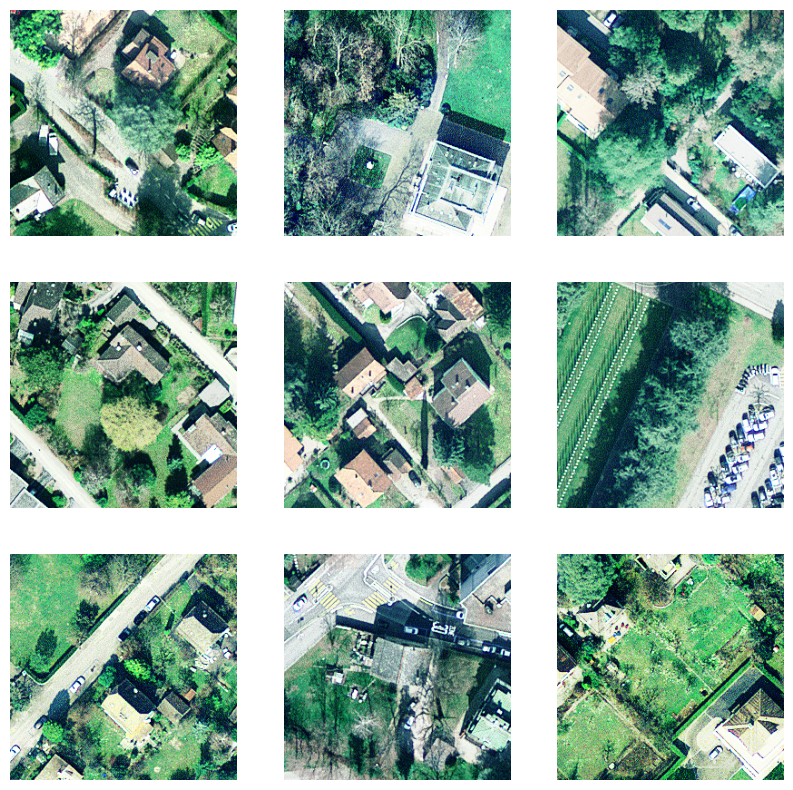

In [138]:
plot_raster(train_images_list)

We create the list of the masks for training, validation and test as well

In [20]:
train_labels_list = create_file_list(train_labels_path)
val_labels_list = create_file_list(val_labels_path)
test_labels_list = create_file_list(test_labels_path)

In [21]:
label_0 = io.imread(train_labels_list[0])
print('Mask shape: {}'.format(label_0.shape))

Mask shape: (250, 250, 3)


In [22]:
label_0.dtype

dtype('uint8')

We plot the masks of the images we saw before

In [25]:
def plot_masks(masks_list):
    fig_rows = 3
    fig_cols = 3
    fig, ax = plt.subplots(nrows=fig_rows, ncols=fig_cols, figsize=(10, 10))
    index = 0
    for col in range(0, fig_cols):
        for row in range(0, fig_rows):
            mask = io.imread(masks_list[index])
            ax[row, col].set_axis_off()
            ax[row, col].imshow(mask)
            index += 1

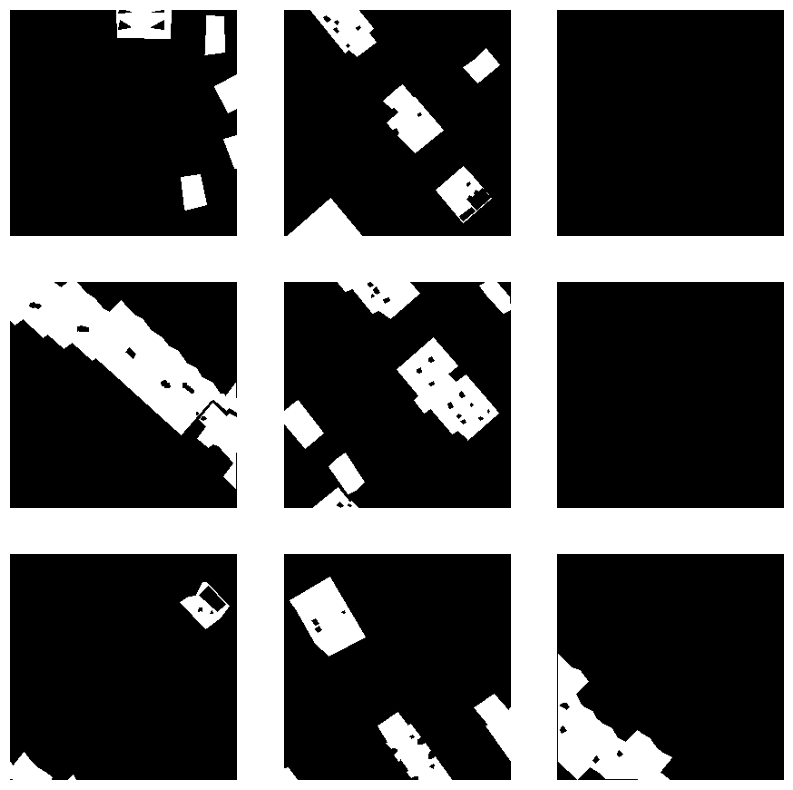

In [26]:
plot_masks(train_labels_list)

### Data augmentation
Since the dataset is a small one we use [data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation) to increase the number of images for training. There are two approaches to data augmentation. One is to add the transformations to the model as a Sequence layer that includes the transformations to apply to the input images and their masks. The augmentation layer will be applied to the training set. The second approach is to transform the dataset outside the model and before training. In this notebook we will follow the second approach. In order to create the new images and masks we define a function that takes in input the set of images and masks and will return the new sets with the new images and masks 

In [174]:
def augment(images_list, target_img_folder, masks_list, target_msk_folder):
    def transform_path(source_path, target_folder, transformation):
        source_folder = str(Path(source_path).parent)
        name = Path(source_path).name
        prefix = name[:-4]
        transform_path = target_folder + '/' + prefix + '_' + transformation + '.png'
        return transform_path
    
    def aug_operation(name, tensor):
        
        def flip(tensor):
            return tf.image.flip_up_down(tensor)

        def rotate(tensor):
            return tf.image.rot90(tensor)
        
        if (name=='rotate'):
            return rotate(tensor)

        if (name=='flip'):
            return flip(tensor)

    transformations = ['rotate', 'flip']
    
    def transform(path_list, target_folder):
        transformed_list = []
        for path in path_list:
            for transformation in transformations:
                t_path = transform_path(path, target_folder, transformation)
                data_array = get_image(path)
                t = tf.convert_to_tensor(data_array, dtype='uint8')
                transformed_t = aug_operation(transformation, t)
                transformed_data = Image.fromarray(transformed_t.numpy().astype("uint8"))
                transformed_data.save(t_path)
                transformed_list.append(t_path)
        return transformed_list
    
    img_list = transform(images_list, target_img_folder)
    msk_list = transform(masks_list, target_msk_folder)
    
    return img_list, msk_list

In [175]:
target_img_folder = DATA_DIR + 'train/transformed_images/'
target_msk_folder = DATA_DIR + 'train/transformed_masks/'

In [176]:
t_img_list, t_msk_list = augment(train_images_list, target_img_folder, train_labels_list, target_msk_folder)

In [173]:
len(t_img_list), len(t_msk_list)

(488, 488)

In [112]:
i = 110
img_path = train_images_list[i]
img_path

'..\\data\\epfl_buildings\\train\\images\\DOP25_LV03_1301_11_2015_1_15_497562.5_119812.5.png'

In [113]:
msk_path = train_labels_list[i]
msk_path

'..\\data\\epfl_buildings\\train\\labels\\DOP25_LV03_1301_11_2015_1_15_497562.5_119812.5_label.png'

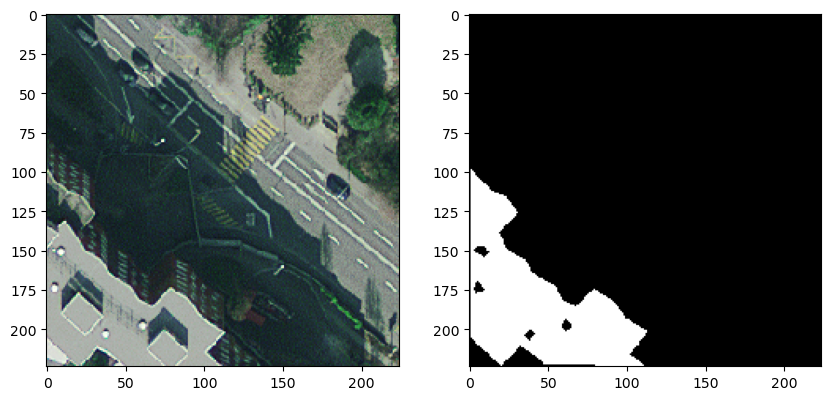

In [116]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
ax[0].imshow(img_to_array(load_img(img_path, target_size=img_size)).astype("uint8"))
ax[1].imshow(img_to_array(load_img(msk_path, target_size=img_size)).astype("uint8"))

In [98]:
img_folder = str(Path(img_path).parent)
img_name = Path(img_path).name
img_prefix = img_name[:-4]
img_prefix

'DOP25_LV03_1301_11_2015_1_15_497562.5_119812.5'

In [117]:
msk_folder = str(Path(msk_path).parent)
msk_name = Path(msk_path).name
msk_prefix = msk_name[:-4]
msk_prefix

'DOP25_LV03_1301_11_2015_1_15_497562.5_119812.5_label'

In [99]:
img = train_input_imgs[i]
img_t = tf.convert_to_tensor(img, dtype='uint8')
img_t.shape

TensorShape([224, 224, 3])

In [100]:
msk = train_targets[i]
msk_t = tf.convert_to_tensor(msk, dtype='uint8')
msk_t.shape

TensorShape([224, 224, 1])

In [101]:
def flip(img):
    return tf.image.flip_up_down(img)

In [102]:
def rotate(img):
    return tf.image.rot90(img)

In [103]:
flipped_img_t = flip(img_t)
flipped_img_t.shape

TensorShape([224, 224, 3])

In [104]:
flipped_msk_t = flip(msk_t)
flipped_msk_t.shape

TensorShape([224, 224, 1])

In [105]:
rotated_img_t = rotate(img_t)
rotated_img_t.shape

TensorShape([224, 224, 3])

In [106]:
rotated_msk_t = rotate(msk_t)
rotated_msk_t.shape

TensorShape([224, 224, 1])

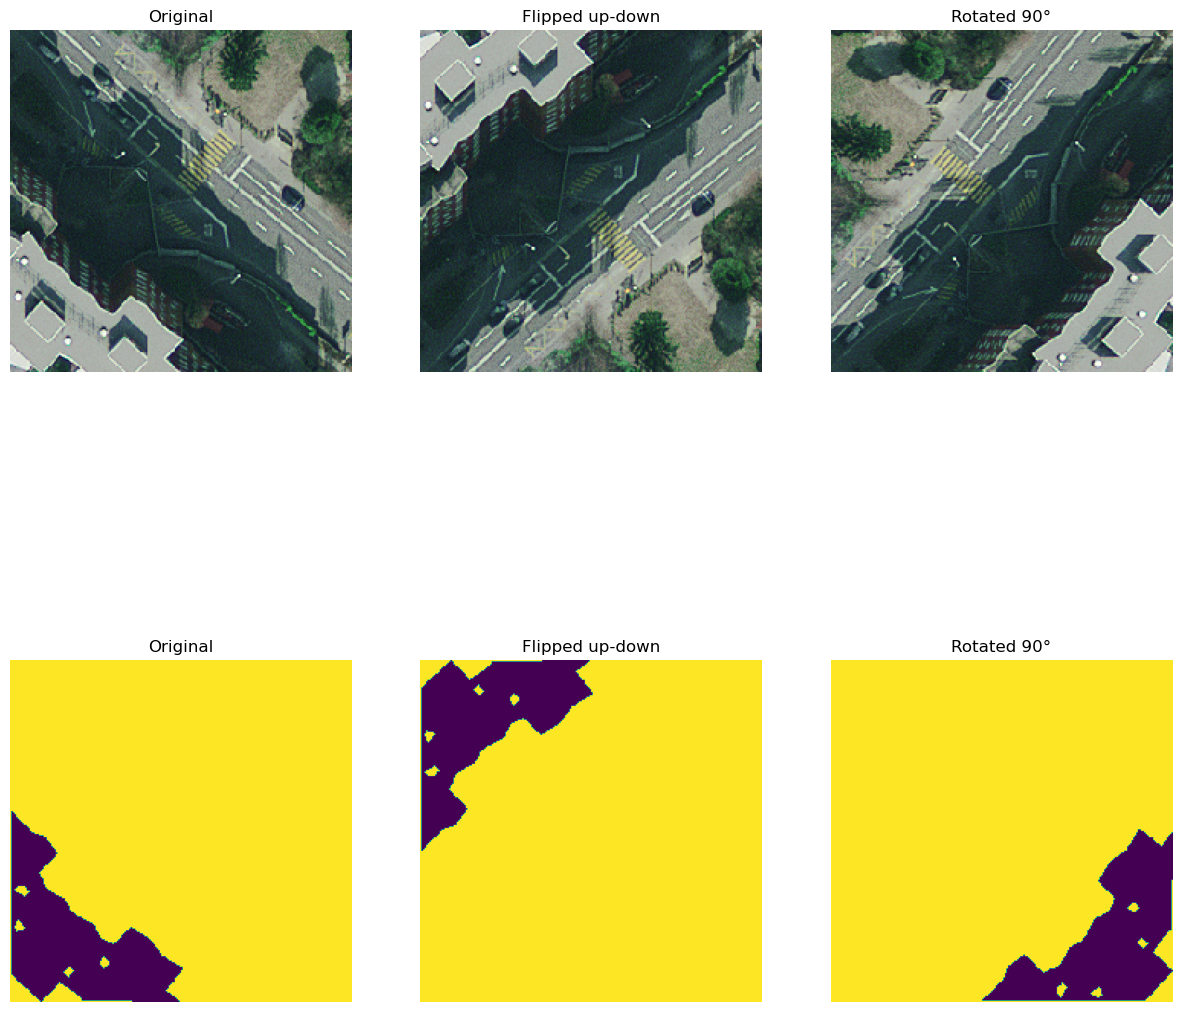

In [107]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 15))
ax[0,0].imshow(img_t)
ax[0,0].set_axis_off()
ax[0,0].set_title('Original')
ax[1,0].imshow(msk_t)
ax[1,0].set_axis_off()
ax[1,0].set_title('Original')

ax[0,1].imshow(flipped_img_t.numpy().astype("uint8"))
ax[0,1].set_title('Flipped up-down')
ax[0,1].set_axis_off()
ax[1,1].imshow(flipped_msk_t.numpy().astype("uint8"))
ax[1,1].set_title('Flipped up-down')
ax[1,1].set_axis_off()

ax[0,2].imshow(rotated_img_t.numpy().astype("uint8"))
ax[0,2].set_title('Rotated 90°')
ax[0,2].set_axis_off()
ax[1,2].imshow(rotated_msk_t.numpy().astype("uint8"))
ax[1,2].set_title('Rotated 90°')
ax[1,2].set_axis_off()

## Data preparation
We load the data into Keras datasets for the training and validation. The images and masks must be converted into tensors and put in batches.

In [27]:
import random
random.Random(1337).shuffle(train_images_list)
random.Random(1337).shuffle(train_labels_list)

We load images and masks into PIL format and convert them to NumPy arrays.

In [119]:
def get_image(path, img_size=None):
    img = img_to_array(load_img(path, target_size=img_size))
    img.astype('uint8')
    return img 

In [118]:
def get_mask(path, img_size=None):
    msk = img_to_array(load_img(path, target_size=img_size))
    band_0 = msk[:,:,0]
    band_0 = np.expand_dims(band_0, axis=-1)
    band_0 = band_0.astype('uint8') - 255
    return band_0

In [57]:
img_size = (224, 224)
num_train_imgs = len(train_images_list)
train_input_imgs = np.zeros((num_train_imgs,) + img_size + (3,), dtype="uint8")
train_targets = np.zeros((num_train_imgs,) + img_size + (1,), dtype="uint8")
for i in range(num_train_imgs):
    train_input_imgs[i] = get_image(train_images_list[i], img_size)
    train_targets[i] = get_mask(train_labels_list[i], img_size)

We create an array of 224x224 RGB images and and an array of binary masks for training. Before creating the array we have to set the space for the augmented images and masks

In [58]:
train_input_imgs.shape, train_targets.shape

((244, 224, 224, 3), (244, 224, 224, 1))

Then an array of RGB images and binary masks for validation

In [59]:
num_val_imgs = len(val_images_list)
val_input_imgs = np.zeros((num_val_imgs,) + img_size + (3,), dtype="uint8")
val_targets = np.zeros((num_val_imgs,) + img_size + (1,), dtype="uint8")
for i in range(num_val_imgs):
    val_input_imgs[i] = get_image(val_images_list[i], img_size)
    val_targets[i] = get_mask(val_labels_list[i], img_size)

In [60]:
val_input_imgs.shape

(30, 224, 224, 3)

In [61]:
num_test_imgs = len(test_images_list)
test_input_imgs = np.zeros((num_test_imgs,) + img_size + (3,), dtype="uint8")
test_targets = np.zeros((num_test_imgs,) + img_size + (1,), dtype="uint8")
for i in range(num_test_imgs):
    test_input_imgs[i] = get_image(test_images_list[i], img_size)
    test_targets[i] = get_mask(test_labels_list[i], img_size)

and finally an array of RGB images and masks for test

In [62]:
test_input_imgs.shape

(31, 224, 224, 3)

## Building the encoder-decoder model
We use again the encoder-decoder model we used in a previous semantic segmentation task. The model includes the data augmentation step, three convolutional blocks for the downsamplig, and three transpose convolutional blocks for upsampling.

In [131]:
def build_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = data_augmentation(inputs)
    x = layers.Rescaling(1./255)(x)

    x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)

    x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)

    x = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)

    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)

    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)

    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)

    outputs = layers.Conv2D(num_classes, 3, activation="sigmoid", padding="same")(x)
    model = keras.Model(inputs, outputs)
    return model

In [132]:
model = build_model(img_size=img_size, num_classes=2)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 112, 112, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 28, 28, 256)    │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 56, 56, 256)    │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 56, 56, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 112, 112, 128)  │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 112, 112, 64)   │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 224, 224, 64)   │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 224, 224, 2)    │         1,154 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,880,066 (10.99 MB)

 Trainable params: 2,880,066 (10.99 MB)

 Non-trainable params: 0 (0.00 B)

In [133]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")  #

callbacks = [
    keras.callbacks.ModelCheckpoint("rooftop_segmentation.keras",
    save_best_only=True)
]

In [69]:
history = model.fit(train_input_imgs, train_targets,
                    epochs=100,
                    callbacks=callbacks,
                    batch_size=5,
                    validation_data=(val_input_imgs, val_targets))

Epoch 1/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.3366 - val_loss: 0.3079
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.3159 - val_loss: 0.3289
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.3289 - val_loss: 0.3400
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.3091 - val_loss: 0.3267
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.3495 - val_loss: 0.3231
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.3391 - val_loss: 0.3228
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.3132 - val_loss: 0.3045
Epoch 8/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.3267 - val_loss: 0.3211
Epoch 9/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.3107 - val_loss: 0.3212
Epoch 10/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.3048 - val_loss: 0.3255
Epoch 11/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.3247 - val_loss: 0.3132
Epoch 12/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step

In [70]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]

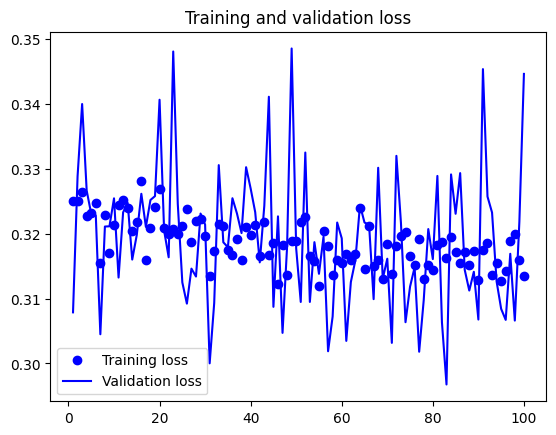

In [71]:
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

In [72]:
best_model = keras.models.load_model("rooftop_segmentation.keras")

In [84]:
def plot_predicted_mask(test_img, test_mask, model):
  fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
  predicted_mask = model.predict(np.expand_dims(test_image, 0))[0][:,:,0]
  predicted_mask_ch1 = np.expand_dims(predicted_mask, 2)

  ax[0].axis("off")
  ax[0].set_title('Test image')
  ax[0].imshow(array_to_img(test_image))
  ax[1].axis("off")
  ax[1].set_title('Mask')
  ax[1].imshow(array_to_img(test_mask))
  ax[2].axis("off")
  ax[2].set_title('Predicted')
  ax[2].imshow(array_to_img(predicted_mask_ch1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


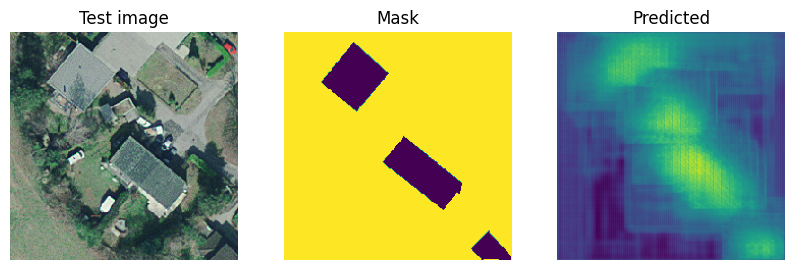

In [87]:
i = 2
test_image = test_input_imgs[i]
test_target = test_targets[i]
plot_predicted_mask(test_image,test_target, best_model)